# Aim

Try out an LQG delay model and see if it optimally controls a toy AR problem.

In [20]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import linalg as la
from sealrtc.controllers import LQG, Openloop
from sealrtc.controllers.identifier import vib_coeffs
from sealrtc.controllers.dare import solve_dare
from sealrtc import rms
from scipy.stats import multivariate_normal as mvn
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# constants
fs = 100.0 # Hz
dt = 1 / fs # s
fcen = 10.0 # Hz
k = 1e-2
sigma_w = 0.1
sigma_v = 0.1
a1, a2 = vib_coeffs(fcen, k)

In [4]:
# system matrices for a sliiiightly wrong model
lqg_vib = LQG(
    np.array([[a1, a2], [1, 0]]),
    np.array([[1], [0]]),
    np.array([[1, 0]]),
    np.array([[sigma_w ** 2, 0], [0, 0]]),
    np.array([[sigma_v ** 2]]),
    np.eye(2),
    0.01 * np.eye(1)
)

print(lqg_vib)

Solved DARE with slycot.
Solved DARE with slycot.
LQG observer and controller with state size 2, input size 1 and measurement size 1.


In [5]:
ol = lambda meas: (np.array([0.0]), 1)
integ = lambda meas: (-0.1 * meas, 1)
lqg_vib.improvement(ol, integ)

100%|██████████| 999/999 [00:00<00:00, 1612.21it/s]


[8.245352977978913, 7.1382036870750865]

Seems good enough, but of course these aren't the actual dynamics: I've got the input hitting the vibration mode, and of course it doesn't work that way. Instead, here's a steering-model vibration, with no delay.

Our state was previously $\vec{x}[n] = \begin{bmatrix} x_n & x_{n-1} \end{bmatrix}$, and will now be $\vec{x}[n] = \begin{bmatrix} x_n & x_{n-1} & u_n\end{bmatrix}$.

In [6]:
steervib = LQG(
    np.array([[a1, a2, 0], [0, 1, 0], [0, 0, 0]]), # A (time evolution dynamics)
    np.array([[0], [0], [1]]), # B (input to state)
    np.array([[1, 0, 1]]), # C (state to measurement)
    np.array([[sigma_w ** 2, 0, 0], [0, 0, 0], [0, 0, 0]]), # W (time evolution noise)
    np.array([[sigma_v ** 2]]), # V (measurement noise)
    np.eye(3), # Q (LQR state cost)
    0.01 * np.eye(1) # R (LQR input cost)
)

slycot error 
The computed dimension of the solution does not
equal N
Solved DARE with scipy.
slycot error 
The computed dimension of the solution does not
equal N
scipy error Failed to find a finite solution.
Discrete ARE solve failed, falling back to iterative solution.


/Users/adityasengupta/research/ao/sealrtc/sealrtc/controllers/dare.py:8: RuntimeWarning: overflow encountered in matmul
  return A.T @ P @ A - (A.T @ P @ B) @ np.linalg.pinv(B.T @ P @ B + R) @ (B.T @ P @ A) + Q
/Users/adityasengupta/research/ao/sealrtc/sealrtc/controllers/dare.py:8: RuntimeWarning: invalid value encountered in matmul
  return A.T @ P @ A - (A.T @ P @ B) @ np.linalg.pinv(B.T @ P @ B + R) @ (B.T @ P @ A) + Q


RuntimeError: Iterative solve failed in 1000 iterations.

In [7]:
# system matrices for a sliiiightly wrong model
lqg_vib = LQG(
    np.array([[a1, a2], [1, 0]]),
    np.array([[0], [0]]),
    np.array([[1, 0]]),
    np.array([[sigma_w ** 2, 0], [0, 0]]),
    np.array([[sigma_v ** 2]]),
    np.eye(2),
    0.01 * np.eye(1)
)

print(lqg_vib)

Solved DARE with slycot.
Solved DARE with slycot.
LQG observer and controller with state size 2, input size 1 and measurement size 1.


In [8]:
lqg_vib.Pcon

array([[ 233.24047557, -186.3397024 ],
       [-186.3397024 ,  228.45155351]])

Apparently A-C-D control doesn't need an ARE at all. I'll try writing that in an ad hoc way, see if it does anything to the control problem, and then add it into the LQG class if it works.

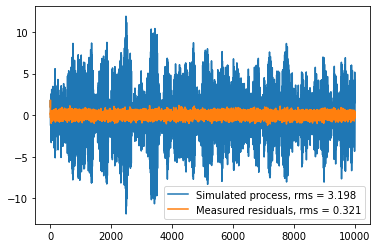

In [138]:
A = np.array([[a1, a2], [1, 0]])
C = np.array([[1, 0]])
D = np.array([[1]])
W = np.array([[0.1, 0], [0, 0]])
V = np.array([[0.001]])
P = solve_dare(A.T, C.T, W, V, verbose=False)
K = P @ C.T @ np.linalg.inv(C @ P @ C.T + V)
L = -np.linalg.inv(D.T @ D) @ D.T @ C
process_dist = mvn(cov=W, allow_singular=True)
measure_dist = mvn(cov=V, allow_singular=True)
nsteps = 10000
states = np.zeros((nsteps, 2))
measurements = np.zeros((nsteps, 1))
states[0] = np.array([1, 0])
x = states[0]
measurements[0] = C @ states[0]
u = np.array([0.0]) 
for i in range(1, nsteps):
    states[i] = A @ states[i - 1] + process_dist.rvs()
    x = A @ x
    y = C @ states[i] + measure_dist.rvs()
    x = x + K @ (y - C @ x)
    measurements[i] = y + D @ u
    u = L @ A @ x # you have to compute the next command *before* you see the next state

plt.plot(states[:,0], label=f"Simulated process, rms = {round(rms(states[1:,0]), 3)}")
plt.plot(measurements, label=f"Measured residuals, rms = {round(rms(measurements[1:]), 3)}")
plt.legend()

Poyneer and Veran (2010) claims you can do this in what I'm calling A-B-C control, and they provide the matrices.

In [119]:
Al = la.block_diag(np.array([[0, 0], [1, 0]]), A)
Bl = np.array([[1], [0], [0], [0]])
Cl = np.array([[1, 0, 1, 0]])
W = la.block_diag(np.zeros((2,2)), np.array([[0.1, 0], [0, 0]]))
V = np.array([[0.001]])
Pl_obs = solve_dare(Al.T, Cl.T, W, V, verbose=False)
Pl_con = solve_dare(Al, Bl, Cl.T @ Cl, np.eye(1))
K = Pl @ Cl.T @ np.linalg.inv(Cl @ Pl @ Cl.T + V)

process_dist = mvn(cov=W, allow_singular=True)
measure_dist = mvn(cov=V, allow_singular=True)

Solved DARE with slycot.


In [120]:
steer = LQG(Al, Bl, Cl, W, V, Cl.T @ Cl, np.eye(1))

Solved DARE with slycot.
Solved DARE with slycot.


In [122]:
ol = lambda meas: (np.array([0]), 1)
integ = lambda meas: (-0.1 * meas, 1)
steer.improvement(ol, integ)

100%|██████████| 999/999 [00:00<00:00, 1615.40it/s]


[1.9524992548748497, 1.8035712599154718]

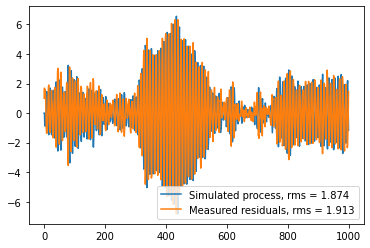

In [133]:
nsteps = 1000
states = np.zeros((nsteps, steer.state_size))
measurements = np.zeros((nsteps, 1))
states[0] = np.array([0, 0, 1, 0])
x = states[0]
measurements[0] = steer.C @ states[0]
u = np.array([0.0])
for i in range(1, nsteps):
    states[i] = steer.A @ states[i - 1] + steer.B @ u + steer.process_dist.rvs()
    x = steer.A @ x + steer.B @ u
    y = steer.C @ states[i] + steer.measure_dist.rvs()
    x = x + steer.K @ (y - steer.C @ x)
    measurements[i] = y 
    u = steer.L @ x # you have to compute the next command *before* you see the next state

plt.plot(states[:,0], label=f"Simulated process, rms = {round(rms(states[1:,0]), 3)}")
plt.plot(measurements, label=f"Measured residuals, rms = {round(rms(measurements[1:]), 3)}")
plt.legend()

Hmm doesn't seem to work. I'll sue Lisa Poyneer. 

In principle, we should have a full state-space description, [A B C D], because B terms would be needed for any steering that affects the actual underlying random process that's causing the motion. Such as...a generic nth-order plant model! 